#XGBoost Classification

This notebook performs XGBoost classification using embeddings extracted from the Galaxy10 dataset with a ResNet-101 model pretrained on ImageNet.

We include:
- Grid search for best parameters
- Accuracy, balanced accuracy, precision, recall, F1
- Confusion matrix and per-class report
- Hierarchical class relation analysis

## Imports

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly.express as px
from xgboost import DMatrix


## PCA on ResNet101 Embeddings

Applies PCA to reduce the dimensionality of the entire dataset using the precomputed ResNet101 embeddings.


In [50]:
# Load data
data = np.load('Galaxy10_Embedding_vectors/galaxy10_resnet101_embeddings_augmented_balanced.npz', allow_pickle=True)

# Separate train, val, and test
X_train = data['train_features']
y_train = data['train_labels']
X_val = data['val_features']
y_val = data['val_labels']
X_test = data['test_features']
y_test = data['test_labels']
class_names = data['class_names']

print(f"Original Train size: {X_train.shape[0]}")
print(f"Original Validation size: {X_val.shape[0]}")
print(f"Original Test size: {X_test.shape[0]}")
print(f"Original Embedding dimension: {X_train.shape[1]}")

# PCA to keep 99% variance (fit only on training data)
pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Reduced Train dimension: {X_train_pca.shape[1]}")
print(f"Reduced Validation dimension: {X_val_pca.shape[1]}")
print(f"Reduced Test dimension: {X_test_pca.shape[1]}")


Original Train size: 48970
Original Validation size: 3269
Original Test size: 3268
Original Embedding dimension: 2048
Reduced Train dimension: 161
Reduced Validation dimension: 161
Reduced Test dimension: 161


## Grid Search for Optimal Parameters

In [51]:
n_estimators_values = [100, 200, 500]
learning_rate_values = [0.01, 0.05, 0.1, 0.15, 0.2]
max_depth_values = [2, 3, 5, 7, 9, 11, 13]
results = []

for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        for max_depth in max_depth_values:
            model = XGBClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                tree_method='hist',
                device='cuda',
                eval_metric='mlogloss',
                random_state=42,
                verbosity=0
            )

            model.fit(X_train_pca, y_train)

            # Use inplace_predict from the Booster
            booster = model.get_booster()

            # Predict using inplace_predict (works only on NumPy arrays, not DMatrix)
            y_val_pred = booster.inplace_predict(X_val_pca)

            # Convert raw predictions (floats) to integer class labels
            y_val_pred = np.argmax(y_val_pred.reshape(-1, len(np.unique(y_train))), axis=1)

            acc = accuracy_score(y_val, y_val_pred)
            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'accuracy': acc
            })

results_df = pd.DataFrame(results)


## Plot Accuracy

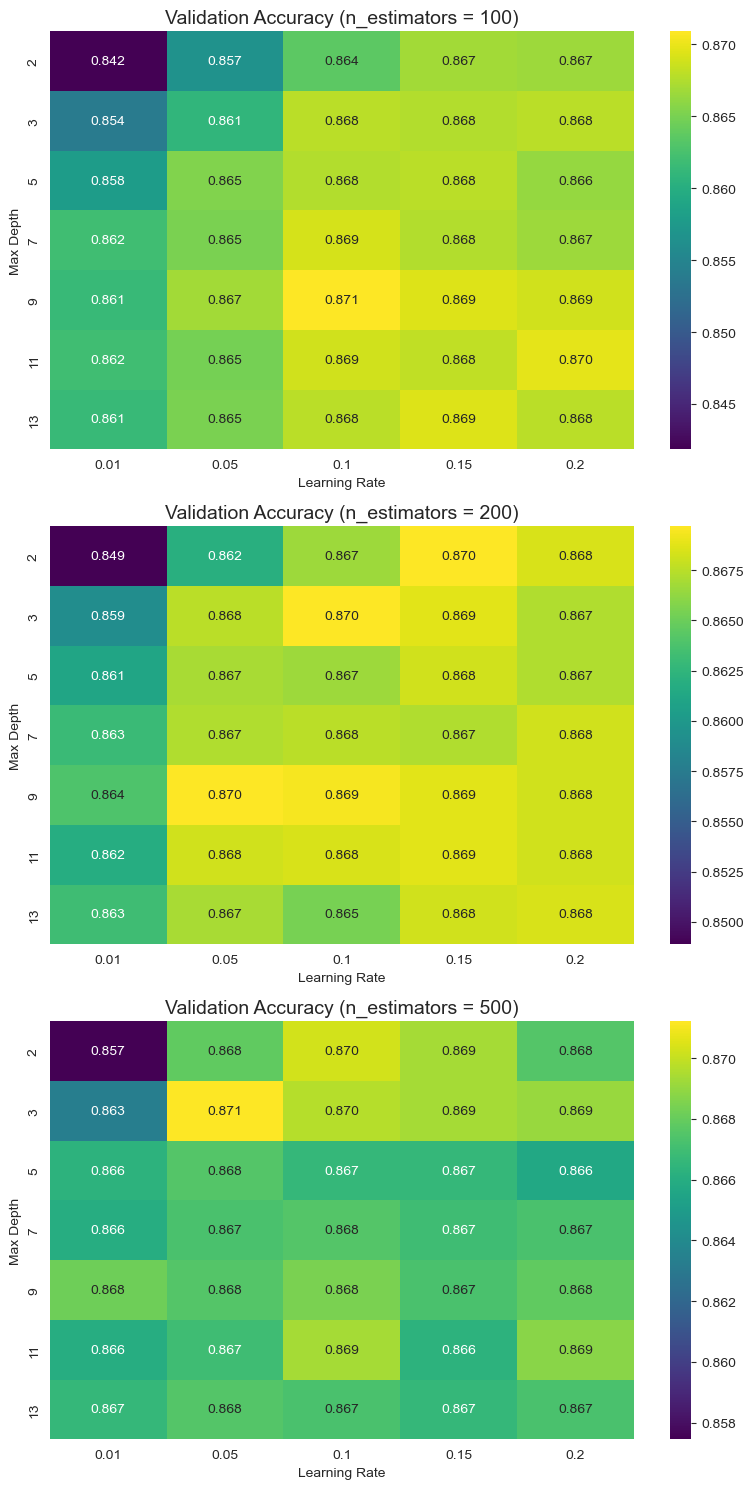

In [52]:
# Get unique n_estimators values
n_estimators_vals = sorted(results_df['n_estimators'].unique())
n_rows = len(n_estimators_vals)

# Create subplots
fig, axes = plt.subplots(n_rows, 1, figsize=(8, 5 * n_rows), squeeze=False)

# Plot heatmaps for each n_estimators value
for i, n_est in enumerate(n_estimators_vals):
    subset = results_df[results_df['n_estimators'] == n_est]
    heatmap_data = subset.pivot(index='max_depth', columns='learning_rate', values='accuracy')

    if heatmap_data.empty:
        continue

    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='viridis', ax=axes[i, 0])
    axes[i, 0].set_title(f'Validation Accuracy (n_estimators = {n_est})', fontsize=14)
    axes[i, 0].set_xlabel('Learning Rate')
    axes[i, 0].set_ylabel('Max Depth')

plt.tight_layout()
plt.show()


## Selecting the Best Hyperparameters

This block locates the combination of hyperparameters that yielded the highest validation accuracy during grid search.
It extracts the best values for `n_estimators`, `learning_rate`, and `max_depth`, which will be used for final model training and evaluation.


In [53]:
# Select best hyperparameters
best = results_df.loc[results_df['accuracy'].idxmax()]

best_n_estimators = best['n_estimators']
best_learning_rate = best['learning_rate']
best_max_depth = best['max_depth']

print(f"Best parameters -> n_estimators: {best_n_estimators}, "
      f"learning_rate: {best_learning_rate}, "
      f"max_depth: {best_max_depth}")


Best parameters -> n_estimators: 500.0, learning_rate: 0.05, max_depth: 3.0


## Evaluate XGBoost on Test Set

Trains the XGBoost classifier with the best parameters found on the training set, then evaluates it on the test set using accuracy, balanced accuracy, macro precision, recall, and F1 score.

In [54]:
# Ensure hyperparameters are the correct type
n_estimators_int = int(best_n_estimators)
learning_rate_float = float(best_learning_rate)
max_depth_int = int(best_max_depth)

# Train XGBoost with best hyperparameters (GPU enabled)
xgb_final = XGBClassifier(
    n_estimators=n_estimators_int,
    learning_rate=learning_rate_float,
    max_depth=max_depth_int,
    tree_method='hist',
    device='cuda',
    eval_metric='mlogloss',
    random_state=42,
    verbosity=1
)
xgb_final.fit(X_train, y_train)

# GPU-safe prediction using inplace_predict (no warnings)
y_pred = xgb_final.get_booster().inplace_predict(X_test)
y_pred = np.argmax(y_pred.reshape(-1, len(np.unique(y_test))), axis=1)

# Evaluate on test set
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

# Print results
print(f"Accuracy:            {acc:.4f}")
print(f"Balanced Accuracy:   {bal_acc:.4f}")
print(f"Macro Precision:     {precision:.4f}")
print(f"Macro Recall:        {recall:.4f}")
print(f"Macro F1 Score:      {f1:.4f}")


Accuracy:            0.8724
Balanced Accuracy:   0.7412
Macro Precision:     0.7676
Macro Recall:        0.7412
Macro F1 Score:      0.7531


## Confusion Matrices

Displays two confusion matrices: one with raw counts and one with row-wise percentages for the test set predictions.


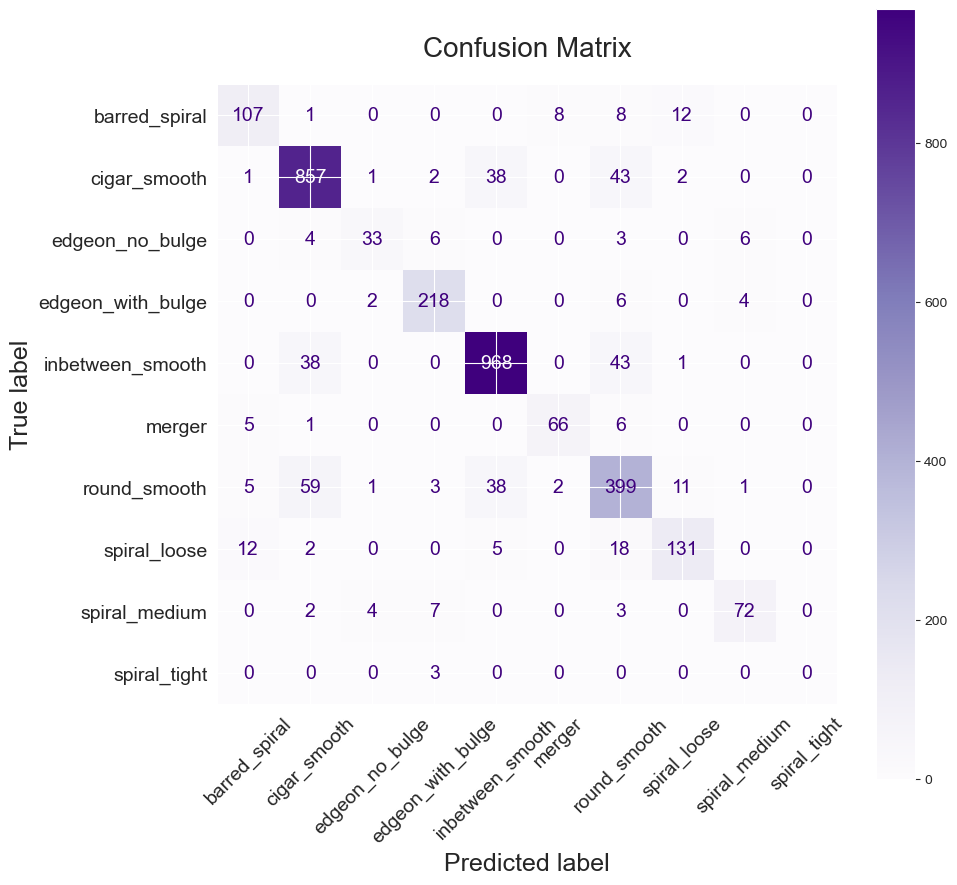

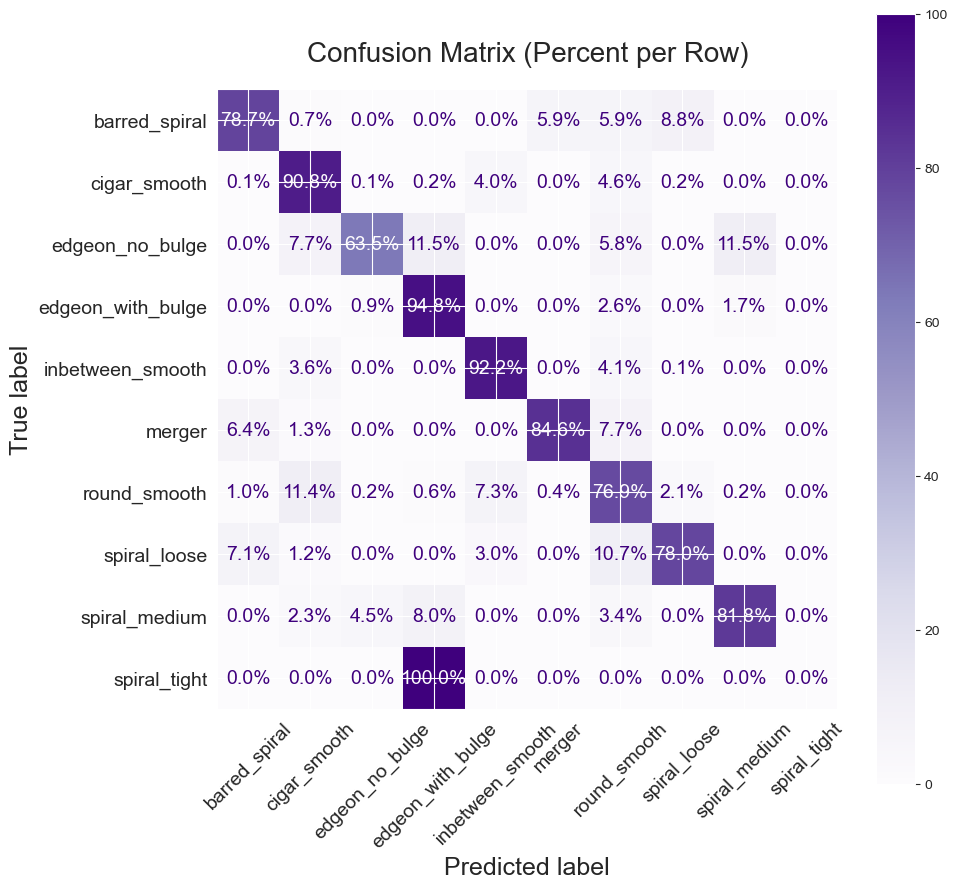

In [55]:
# Confusion matrix (raw counts)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Purples', xticks_rotation=45)

ax.set_title("Confusion Matrix", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)
for text in disp.text_.ravel():
    text.set_fontsize(14)

plt.show()

# Confusion matrix (row-wise percentages)
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, None] * 100
disp_percent = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp_percent.plot(ax=ax, cmap='Purples', xticks_rotation=45, values_format='.1f')

for text in disp_percent.text_.ravel():
    text.set_text(f"{float(text.get_text()):.1f}%")
    text.set_fontsize(14)

ax.set_title("Confusion Matrix (Percent per Row)", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)

plt.show()

## Classification Report

Prints precision, recall, F1 score, and support for each class in the test set.


In [56]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4, zero_division=0))

                   precision    recall  f1-score   support

    barred_spiral     0.8231    0.7868    0.8045       136
     cigar_smooth     0.8890    0.9078    0.8983       944
  edgeon_no_bulge     0.8049    0.6346    0.7097        52
edgeon_with_bulge     0.9121    0.9478    0.9296       230
 inbetween_smooth     0.9228    0.9219    0.9223      1050
           merger     0.8684    0.8462    0.8571        78
     round_smooth     0.7543    0.7688    0.7615       519
     spiral_loose     0.8344    0.7798    0.8062       168
    spiral_medium     0.8675    0.8182    0.8421        88
     spiral_tight     0.0000    0.0000    0.0000         3

         accuracy                         0.8724      3268
        macro avg     0.7676    0.7412    0.7531      3268
     weighted avg     0.8713    0.8724    0.8715      3268



## Hierarchical Clustering of Predicted Classes

We analyzed how the model groups Galaxy10 classes by performing hierarchical clustering based on the **mean embedding** (centroid) of each **predicted class** in the test set.

For each class that was actually predicted by the model, we computed its centroid by averaging the embeddings of all test samples assigned to that class. This approach reflects how the model internally organizes its predictions in feature space.

We used **Ward’s method** on the pairwise **Euclidean distances** between class centroids:

$$
\text{Distance}(C_i, C_j) = \left\| \mu_i - \mu_j \right\|_2
$$

This method reveals how semantically close the predicted classes are according to the model’s learned representation.

> Note: Classes not predicted at all are excluded from the dendrogram.

Skipping class spiral_tight: no predictions in test set.


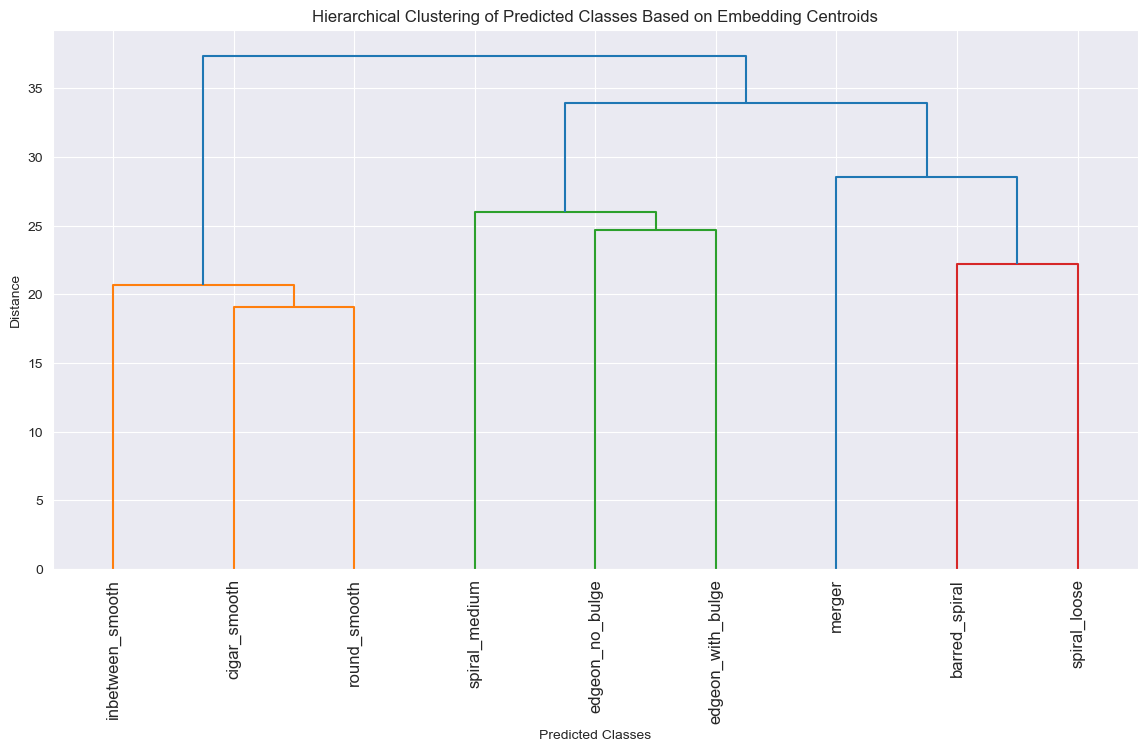

In [57]:
# Make sure class names are a numpy array
class_names = np.array(class_names)

# Find the unique classes predicted by the model
predicted_classes = np.unique(y_pred)

centroids_pred = []
valid_class_names_pred = []

for cls in range(len(class_names)):
    idx = np.where(y_pred == cls)[0]

    if len(idx) == 0:
        print(f"Skipping class {class_names[cls]}: no predictions in test set.")
        continue
    else:
        centroid = np.mean(X_test[idx], axis=0)
        centroids_pred.append(centroid)
        valid_class_names_pred.append(class_names[cls])

centroids_pred = np.array(centroids_pred)
valid_class_names_pred = np.array(valid_class_names_pred)

# Perform hierarchical clustering
linked_pred = linkage(centroids_pred, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 7))
dendrogram(linked_pred, labels=valid_class_names_pred, leaf_rotation=90)
plt.title('Hierarchical Clustering of Predicted Classes Based on Embedding Centroids')
plt.xlabel('Predicted Classes')
plt.ylabel('Distance')
plt.show()